# AI CA 3
### Shayan Maleki
### SID : 810102515


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class DesicionTree:
    class _Node:
        def __init__(self, feature=None, value=None, depth=0, threshold=None):
            self.feature = feature
            self.value = value
            self.children = {}
            self.depth = depth
            self.threshold = threshold  # Added for continuous split

    def __init__(self, max_depth=4):
        self.max_depth = max_depth
        self.root = None
        self.classes_ = None
        self.n_features_ = None
        self.feature_names_ = None
        self.feature_importances_ = None

    def fit(self, X_train, y_train, feature_names=None):
        if feature_names is None and hasattr(X_train, "columns"):
            feature_names = list(X_train.columns)

        X = np.asarray(X_train, dtype=object)
        y = np.asarray(y_train)
        
        self.classes_ = np.unique(y)
        self.n_features_ = X.shape[1]
        
        if feature_names is not None:
            self.feature_names_ = list(feature_names)
        else:
            self.feature_names_ = [f"feature_{i}" for i in range(self.n_features_)]

        self.feature_importances_ = np.zeros(self.n_features_, dtype=float)
        self.root = self._build_tree(X, y, depth=0)
        
        total_gain = self.feature_importances_.sum()
        if total_gain:
            self.feature_importances_ /= total_gain
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=object)
        return np.array([self._traverse(row, self.root) for row in X])

    def visualize(self, feature_names=None):
        if self.root is None:
            return
        
        names = (
            list(feature_names)
            if feature_names is not None
            else self.feature_names_
        )

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_axis_off()
        self._plot_node(ax, self.root, names, x=0.5, y=1.0, width=1.0, level_height=0.15)
        plt.show()

    def _build_tree(self, X, y, depth):
        node = self._Node(feature=None, value=self._majority_class(y), depth=depth)

        if (
            depth >= self.max_depth
            or len(np.unique(y)) == 1
            or X.size == 0
        ):
            return node

        feature, gain, threshold = self._best_split(X, y)
        
        if feature is None or gain <= 0:
            return node

        node.feature = feature
        node.threshold = threshold
        self.feature_importances_[feature] += gain

        if threshold is not None:
            # Continuous split
            left_mask = X[:, feature] <= threshold
            right_mask = ~left_mask
            
            # Left child (<= threshold)
            node.children["left"] = self._build_tree(X[left_mask], y[left_mask], depth + 1)
            # Right child (> threshold)
            node.children["right"] = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        else:
            # Categorical split
            for category in np.unique(X[:, feature]):
                idx = X[:, feature] == category
                child = self._build_tree(X[idx], y[idx], depth + 1)
                node.children[category] = child
                
        return node

    def _best_split(self, X, y):
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        current_entropy = self._entropy(y)

        for feature in range(X.shape[1]):
            column = X[:, feature]
            
            # Check if continuous (numeric types)
            is_continuous = isinstance(column[0], (int, float, np.integer, np.floating))
            
            if is_continuous:
                unique_values = np.unique(column)
                if len(unique_values) <= 1:
                    continue
                
                # Calculate midpoints for thresholds
                thresholds = (unique_values[:-1] + unique_values[1:]) / 2
                
                for thresh in thresholds:
                    left_y = y[column <= thresh]
                    right_y = y[column > thresh]
                    
                    if len(left_y) == 0 or len(right_y) == 0:
                        continue
                        
                    n = len(y)
                    n_l, n_r = len(left_y), len(right_y)
                    e_l, e_r = self._entropy(left_y), self._entropy(right_y)
                    child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
                    
                    gain = current_entropy - child_entropy
                    if gain > best_gain + 1e-12:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = thresh
            else:
                # Discrete logic
                values, counts = np.unique(column, return_counts=True)
                if len(values) <= 1:
                    continue

                feature_entropy = 0.0
                for category, count in zip(values, counts):
                    subset_y = y[column == category]
                    feature_entropy += (count / len(y)) * self._entropy(subset_y)

                gain = current_entropy - feature_entropy
                if gain > best_gain + 1e-12:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = None

        if best_gain <= 0:
            return None, 0.0, None
        return best_feature, best_gain, best_threshold

    def _entropy(self, y):
        probs = np.bincount(y) / len(y)
        probs = probs[probs > 0]
        return -np.sum(probs * np.log2(probs))

    def _majority_class(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def _traverse(self, row, node):
        current = node
        while current.feature is not None and current.children:
            value = row[current.feature]
            
            if current.threshold is not None:
                # Continuous check
                if value <= current.threshold:
                    if "left" in current.children:
                        current = current.children["left"]
                    else:
                        break
                else:
                    if "right" in current.children:
                        current = current.children["right"]
                    else:
                        break
            else:
                # Discrete check
                if value in current.children:
                    current = current.children[value]
                else:
                    break
        return current.value

    def _get_leaf_count(self, node):
        if not node.children:
            return 1
        return sum(self._get_leaf_count(child) for child in node.children.values())

    def _plot_node(self, ax, node, feature_names, x, y, width, level_height):
        if node.feature is None or not node.children:
            text = str(node.value)
            bbox_props = dict(boxstyle="round,pad=0.3", fc="#90EE90", ec="black")
            ax.text(x, y, text, ha="center", va="center", bbox=bbox_props, fontsize=10, zorder=10)
        else:
            fname = feature_names[node.feature]
            if node.threshold is not None:
                text = f"{fname}\n<= {node.threshold:.2f}"
            else:
                text = fname
                
            bbox_props = dict(boxstyle="round,pad=0.3", fc="#ADD8E6", ec="black")
            ax.text(x, y, text, ha="center", va="center", bbox=bbox_props, fontsize=9, zorder=10)

            total_leaves = self._get_leaf_count(node)
            current_x = x - width / 2
            
            # Sort children for consistent plotting: left/right for continuous, alphabetical for discrete
            children_items = list(node.children.items())
            if node.threshold is not None:
                # Ensure 'left' comes first
                children_items.sort(key=lambda item: 0 if item[0] == 'left' else 1)
            
            for key, child in children_items:
                child_leaves = self._get_leaf_count(child)
                child_width = (child_leaves / total_leaves) * width
                child_x = current_x + child_width / 2
                child_y = y - level_height
                
                ax.plot([x, child_x], [y, child_y], 'k-', lw=1, zorder=1)
                
                mid_x = (x + child_x) / 2
                mid_y = (y + child_y) / 2
                
                if node.threshold is not None:
                    edge_label = "True" if key == "left" else "False"
                else:
                    edge_label = str(key)
                    
                ax.text(mid_x, mid_y, edge_label, ha="center", va="center", 
                        bbox=dict(boxstyle="square,pad=0.1", fc="white", ec="none"), fontsize=7)

                self._plot_node(ax, child, feature_names, child_x, child_y, child_width, level_height)
                current_x += child_width


## part1 :


Validation metrics and counts:
              Metric    Value
            Accuracy   0.8800
           Precision   0.9009
              Recall   0.9272
                  F1   0.9139
 True Positives (TP) 191.0000
False Positives (FP)  21.0000
False Negatives (FN)  15.0000
 True Negatives (TN)  73.0000

Confusion Matrix (rows = actual [Positive, Negative], cols = predicted [Positive, Negative]):
[[191  21]
 [ 15  73]]


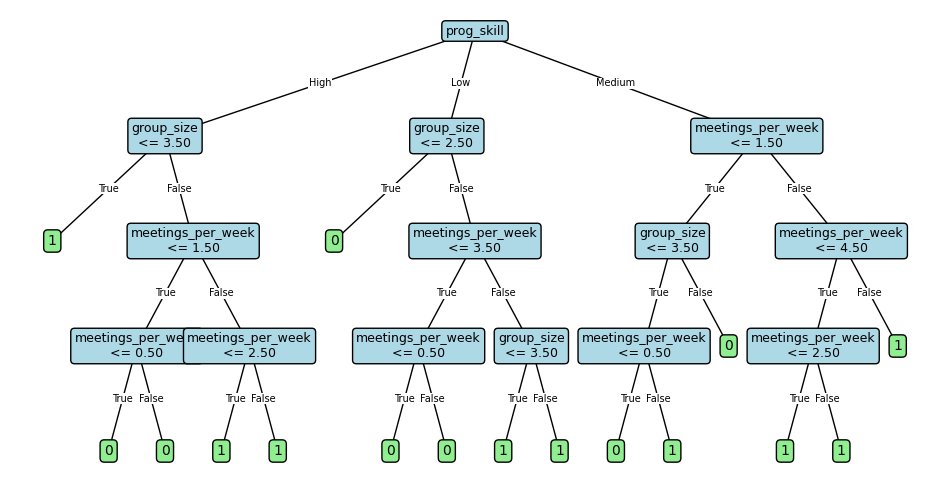

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def confusion_counts(y_true, y_pred, positive=1):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = int(np.sum((y_true == positive) & (y_pred == positive)))
    tn = int(np.sum((y_true != positive) & (y_pred != positive)))
    fp = int(np.sum((y_true != positive) & (y_pred == positive)))
    fn = int(np.sum((y_true == positive) & (y_pred != positive)))
    return tp, fp, fn, tn

def classification_metrics(tp, fp, fn, tn):
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total if total else 0.0
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0.0
    return accuracy, precision, recall, f1

def main():
    # load data
    csv_path = "datas/part1/s1_part1_dataset.csv"
    df = pd.read_csv(csv_path)


    feature_cols = ["group_size", "meetings_per_week", "prog_skill"]
    target_col = "Is_finished"

    X = df[feature_cols].to_numpy(dtype=object)
    y = df[target_col].astype(int).to_numpy()

    # split (70/30)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.30, random_state=404, stratify=y
    )

    tree = DesicionTree(max_depth=4)
    tree.fit(X_train, y_train, feature_names=feature_cols)

    # predict and metrics
    y_pred = tree.predict(X_val)
    tp, fp, fn, tn = confusion_counts(y_val, y_pred, positive=1)
    accuracy, precision, recall, f1 = classification_metrics(tp, fp, fn, tn)

    # metrics table
    metrics_df = pd.DataFrame(
        [
            {"Metric": "Accuracy", "Value": accuracy},
            {"Metric": "Precision", "Value": precision},
            {"Metric": "Recall", "Value": recall},
            {"Metric": "F1", "Value": f1},
            {"Metric": "True Positives (TP)", "Value": tp},
            {"Metric": "False Positives (FP)", "Value": fp},
            {"Metric": "False Negatives (FN)", "Value": fn},
            {"Metric": "True Negatives (TN)", "Value": tn},
        ]
    )

    print("\nValidation metrics and counts:")
    print(metrics_df.to_string(index=False, float_format=lambda v: f"{v:.4f}" if isinstance(v, float) else str(v)))

    # confusion matrix display
    confusion_mat = np.array([[tp, fp],
                              [fn, tn]])
    print("\nConfusion Matrix (rows = actual [Positive, Negative], cols = predicted [Positive, Negative]):")
    print(confusion_mat)
    
    tree.visualize()

if __name__ == "__main__":
    main()


    as we can see the prog_skill is the most important skill.

## test

In [ ]:
import pandas as pd
import numpy as np

test_csv_path = "datas/part1/s1_part1_test.csv"
df_test = pd.read_csv(test_csv_path)

feature_cols = ["group_size", "meetings_per_week", "prog_skill"]
X_test = df_test[feature_cols].to_numpy(dtype=object)

y_test_pred = tree.predict(X_test)

df_output = df_test.copy()
df_output['Is_finished_predicted'] = y_test_pred

output_filename = "s1_part1_predicted.csv"
df_output.to_csv(output_filename, index=False)


## depth 1:


Validation metrics and counts:
              Metric    Value
            Accuracy   0.7933
           Precision   0.8333
              Recall   0.8738
                  F1   0.8531
 True Positives (TP) 180.0000
False Positives (FP)  36.0000
False Negatives (FN)  26.0000
 True Negatives (TN)  58.0000

Confusion Matrix (rows = actual [Positive, Negative], cols = predicted [Positive, Negative]):
[[180  36]
 [ 26  58]]


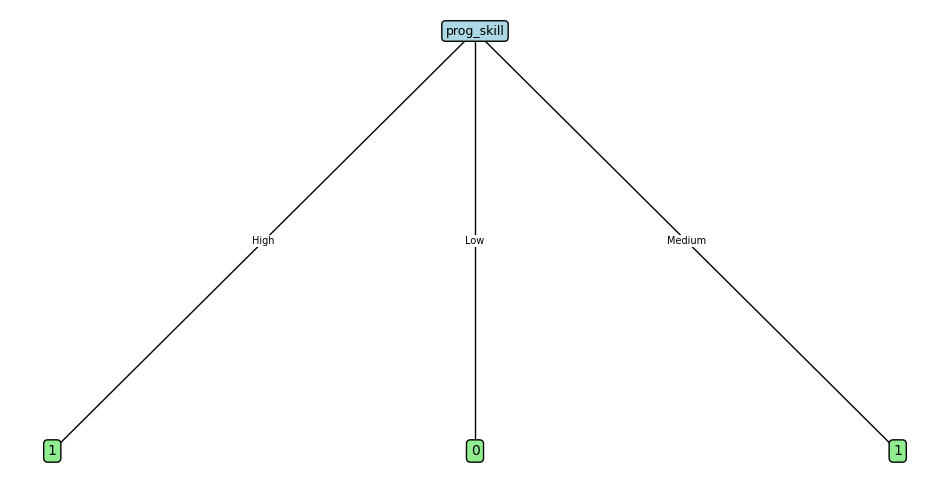

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def confusion_counts(y_true, y_pred, positive=1):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = int(np.sum((y_true == positive) & (y_pred == positive)))
    tn = int(np.sum((y_true != positive) & (y_pred != positive)))
    fp = int(np.sum((y_true != positive) & (y_pred == positive)))
    fn = int(np.sum((y_true == positive) & (y_pred != positive)))
    return tp, fp, fn, tn

def classification_metrics(tp, fp, fn, tn):
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total if total else 0.0
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0.0
    return accuracy, precision, recall, f1

def main():
    # load data
    csv_path = "datas/part1/s1_part1_dataset.csv"
    df = pd.read_csv(csv_path)


    feature_cols = ["group_size", "meetings_per_week", "prog_skill"]
    target_col = "Is_finished"

    X = df[feature_cols].to_numpy(dtype=object)
    y = df[target_col].astype(int).to_numpy()

    # split (70/30)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.30, random_state=404, stratify=y
    )

    tree = DesicionTree(max_depth=1)
    tree.fit(X_train, y_train, feature_names=feature_cols)

    # predict and metrics
    y_pred = tree.predict(X_val)
    tp, fp, fn, tn = confusion_counts(y_val, y_pred, positive=1)
    accuracy, precision, recall, f1 = classification_metrics(tp, fp, fn, tn)

    # metrics table
    metrics_df = pd.DataFrame(
        [
            {"Metric": "Accuracy", "Value": accuracy},
            {"Metric": "Precision", "Value": precision},
            {"Metric": "Recall", "Value": recall},
            {"Metric": "F1", "Value": f1},
            {"Metric": "True Positives (TP)", "Value": tp},
            {"Metric": "False Positives (FP)", "Value": fp},
            {"Metric": "False Negatives (FN)", "Value": fn},
            {"Metric": "True Negatives (TN)", "Value": tn},
        ]
    )

    print("\nValidation metrics and counts:")
    print(metrics_df.to_string(index=False, float_format=lambda v: f"{v:.4f}" if isinstance(v, float) else str(v)))

    # confusion matrix display
    confusion_mat = np.array([[tp, fp],
                              [fn, tn]])
    print("\nConfusion Matrix (rows = actual [Positive, Negative], cols = predicted [Positive, Negative]):")
    print(confusion_mat)
    
    tree.visualize()

if __name__ == "__main__":
    main()


    accuracy drops to 79 percent

## adding the new feature :


Validation metrics:
   Metric    Value
 Accuracy 0.930000
Precision 0.926267
   Recall 0.975728
       F1 0.950355

Most Important Feature: avg_previous_grade (Imp: 1.0000)

Visualizing Tree with Continuous Split...


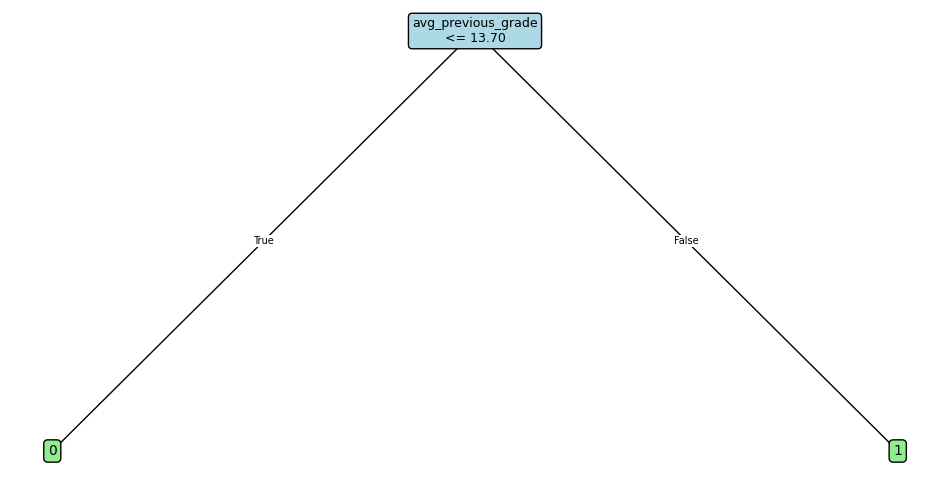

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def confusion_counts(y_true, y_pred, positive=1):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = int(np.sum((y_true == positive) & (y_pred == positive)))
    tn = int(np.sum((y_true != positive) & (y_pred != positive)))
    fp = int(np.sum((y_true != positive) & (y_pred == positive)))
    fn = int(np.sum((y_true == positive) & (y_pred != positive)))
    return tp, fp, fn, tn

def classification_metrics(tp, fp, fn, tn):
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total if total else 0.0
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0.0
    return accuracy, precision, recall, f1

def main():
    csv_path = "datas/part1/s1_part2_dataset.csv"
    df = pd.read_csv(csv_path)



    feature_cols = ["group_size", "meetings_per_week", "prog_skill", "avg_previous_grade"]
    target_col = "Is_finished"

    X = df[feature_cols].to_numpy(dtype=object)
    y = df[target_col].astype(int).to_numpy()

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.30, random_state=404, stratify=y
    )

    tree = DesicionTree(max_depth=1)
    tree.fit(X_train, y_train, feature_names=feature_cols)

    y_pred = tree.predict(X_val)
    tp, fp, fn, tn = confusion_counts(y_val, y_pred, positive=1)
    accuracy, precision, recall, f1 = classification_metrics(tp, fp, fn, tn)

    metrics_df = pd.DataFrame(
        [
            {"Metric": "Accuracy", "Value": accuracy},
            {"Metric": "Precision", "Value": precision},
            {"Metric": "Recall", "Value": recall},
            {"Metric": "F1", "Value": f1},
        ]
    )

    print("\nValidation metrics:")
    print(metrics_df.to_string(index=False))
    
    if tree.feature_importances_ is not None:
        best_idx = np.argmax(tree.feature_importances_)
        print(f"\nMost Important Feature: {tree.feature_names_[best_idx]} (Imp: {tree.feature_importances_[best_idx]:.4f})")

    print("\nVisualizing Tree with Continuous Split...")
    tree.visualize(feature_names=feature_cols)

if __name__ == "__main__":
    main()


## Questions:
how adding a new feature caused higher accuracy with only one depth ?

    the answer is that this new particular feature has a very high information gain and when we split the datas from there it almost haave a pure datas and more depth dont do much differance.
the lesson?

    we learned that with a low quality feature the model has to go over more splits and gets more complecated to get the high accuracy and this would even brings us to the overfitting terrotory (which answers the third question as well)

# part 2
    pre proccessing

In [69]:
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

df = pd.read_csv('datas/part2/part2_dataset.csv')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text_str = str(text)
    lower_text = text_str.lower()
    translator = str.maketrans('', '', string.punctuation)
    no_punct = lower_text.translate(translator)
    tokens = no_punct.split()
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stop_words:
            lemma = lemmatizer.lemmatize(token)
            cleaned_tokens.append(lemma)
            
    return cleaned_tokens

df['tokens'] = df['message_body'].apply(preprocess_text)

unique_words = set()
for tokens in df['tokens']:
    for token in tokens:
        unique_words.add(token)

vocab = sorted(list(unique_words))
word_to_index = {word: i for i, word in enumerate(vocab)}

num_docs = len(df)
num_vocab = len(vocab)

X_freq = [[0] * num_vocab for _ in range(num_docs)]
X_binary = [[0] * num_vocab for _ in range(num_docs)]

for doc_idx, tokens in enumerate(df['tokens']):
    for token in tokens:
        if token in word_to_index:
            word_idx = word_to_index[token]
            X_freq[doc_idx][word_idx] += 1
            X_binary[doc_idx][word_idx] = 1

y = df['is_important'].tolist()


--- Naive Bayes (Multinomial) Results ---
Accuracy:  0.8056
Precision: 0.7407
Recall:    1.0000
F1 Score:  0.8511


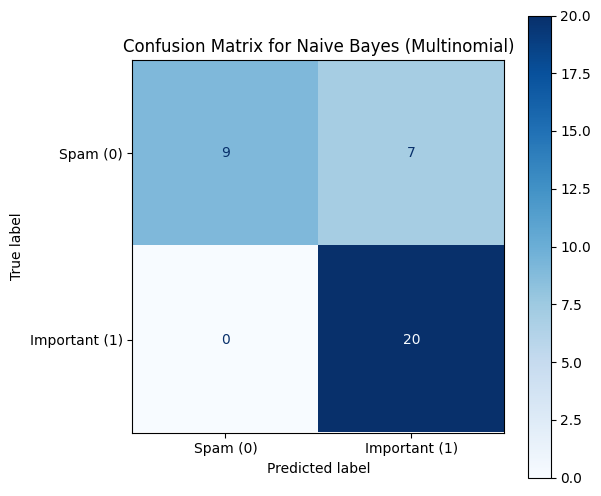

------------------------------
--- Decision Tree (Max Depth=5) Results ---
Accuracy:  0.6667
Precision: 0.6250
Recall:    1.0000
F1 Score:  0.7692


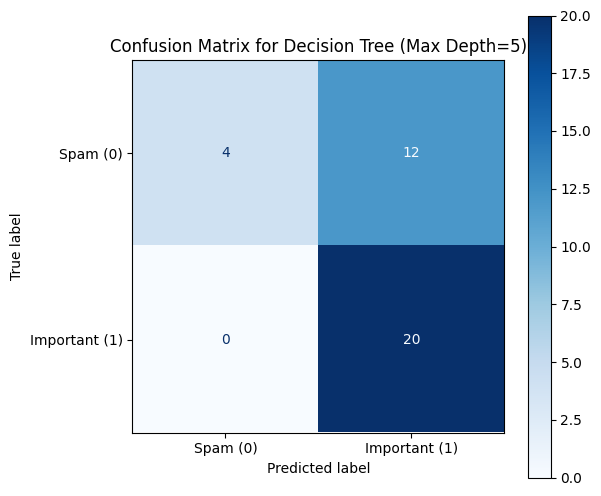

------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


X = np.array(X_binary) 
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


nb_model = BernoulliNB()
nb_model.fit(X_train, y_train)

dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

def evaluate_model(model, X_v, y_v, model_name):
    y_pred = model.predict(X_v)
    
    acc = accuracy_score(y_v, y_pred)
    prec = precision_score(y_v, y_pred, zero_division=0)
    rec = recall_score(y_v, y_pred, zero_division=0)
    f1 = f1_score(y_v, y_pred, zero_division=0)
    
    print(f"--- {model_name} Results ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    cm = confusion_matrix(y_v, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Spam (0)', 'Important (1)'])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    print("-" * 30)

evaluate_model(nb_model, X_val, y_val, "Naive Bayes (bernouli)")

evaluate_model(dt_model, X_val, y_val, "Decision Tree (Max Depth=5)")


## Question 8 : 

    although the words are not independant but in a spam detection looking at certain words individually can increase the potential of being spa like "special" "free" "NOW" 

## Question 9 :

    True independence between words is rare in natural language, but if it existed, the model’s probability estimates would be perfectly calibrated. In practice, when words are correlated, Naive Bayes “double counts” their evidence, causing the model to become overconfident in its predictions; however, since these correlated words usually point toward the same class, the final classification decision remains correct, preserving the model’s accuracy despite the theoretical violation.

In [72]:
import numpy as np
import pandas as pd

df_test = pd.read_csv('datas/part2/part2_test.csv')

df_test['tokens'] = df_test['message_body'].apply(preprocess_text)


num_test_docs = len(df_test)
X_test_binary = [[0] * num_vocab for _ in range(num_test_docs)]

for doc_idx, tokens in enumerate(df_test['tokens']):
    for token in tokens:
        if token in word_to_index:
            word_idx = word_to_index[token]
            X_test_binary[doc_idx][word_idx] = 1

X_test_np = np.array(X_test_binary)


test_preds_nb = nb_model.predict(X_test_np)

test_preds_dt = dt_model.predict(X_test_np)


df_res_nb = df_test[['message_body']].copy()
df_res_nb['is_important_predicted'] = test_preds_nb
df_res_nb.to_csv('part2_predicted_NB.csv', index=False)

df_res_dt = df_test[['message_body']].copy()
df_res_dt['is_important_predicted'] = test_preds_dt
df_res_dt.to_csv('part2_predicted_DT.csv', index=False)



# part 3:

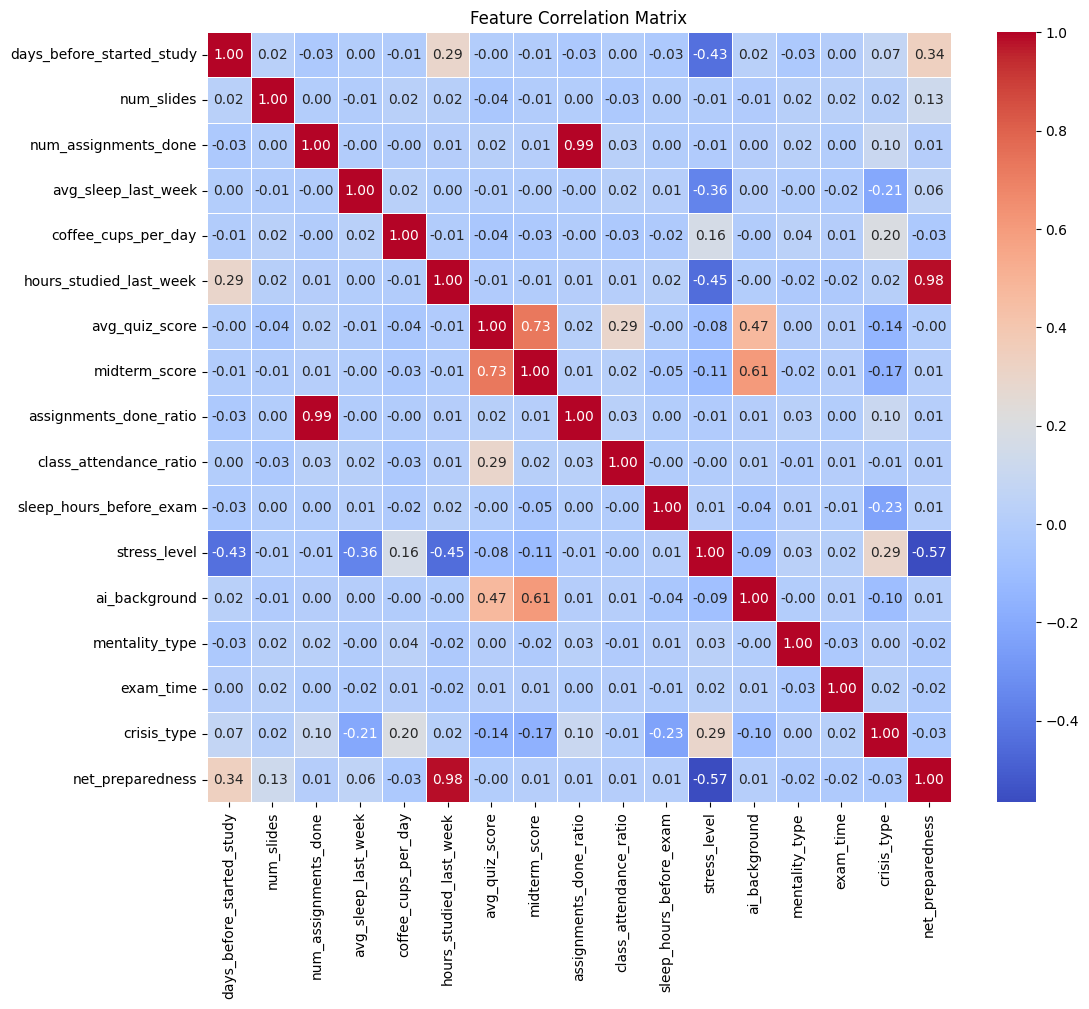

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv('datas/part3/part3_dataset.csv')

# a. Imputation (Missing Values) ---
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Fill missing numeric values with Median (robust to outliers)
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values with Mode (most frequent value)
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])


# b. Scaling 
# Scaling is skipped because Tree-based models (Decision Trees) are invariant to feature scaling.


# c. Outlier Handling 
# Clip numeric values between the 1st and 99th percentiles to remove extreme outliers
for col in numeric_cols:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)


# d. Feature Engineering 
# Create a new feature 'net_preparedness' combining study effort vs. stress
df['net_preparedness'] = (df['hours_studied_last_week'] + (df['num_slides'] / 50)) - (df['stress_level'] * 2)


# e. Encoding 
# 1. Map Ordinal features (preserve order)
background_mapping = {'none': 0, 'basic': 1, 'strong': 2}
exam_time_mapping = {'morning': 0, 'afternoon': 1, 'Evening': 2}

df['ai_background'] = df['ai_background'].map(background_mapping)
df['exam_time'] = df['exam_time'].map(exam_time_mapping)

# 2. Label Encode Nominal features and Target
le_mentality = LabelEncoder()
df['mentality_type'] = le_mentality.fit_transform(df['mentality_type'])

le_target = LabelEncoder()
df['crisis_type'] = le_target.fit_transform(df['crisis_type'])

# Ensure no NaNs remain after mapping
df = df.fillna(0)


# f. Correlation Matrix 
# Plot heatmap to visualize relationships between features
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


## e. Encoding Strategy

    In this phase, I applied two distinct methods depending on the nature of the categorical data. For ordinal features like ai_background and exam_time, I used Manual Mapping to assign specific integer values (e.g., 0, 1, 2) that explicitly preserve their inherent logical order (such as experience levels or time of day). For the nominal feature mentality_type and the target variable crisis_type, I utilized Label Encoding to convert the string categories into unique integers. This approach was chosen because Decision Trees can handle integer-encoded categorical data effectively without the need for One-Hot Encoding, which would unnecessarily increase the dataset’s dimensionality.

## f. correlation matrix

    we can say that the features that have more corr (that are shown with warmer color) have more dependancy to each other and we should merge them or delete one of them to keep the features independent

--- Validation Metrics ---
Overall Accuracy: 0.9092
Macro Precision:  0.9285
Macro Recall:     0.8779
Macro F1 Score:   0.8922


<Figure size 800x600 with 0 Axes>

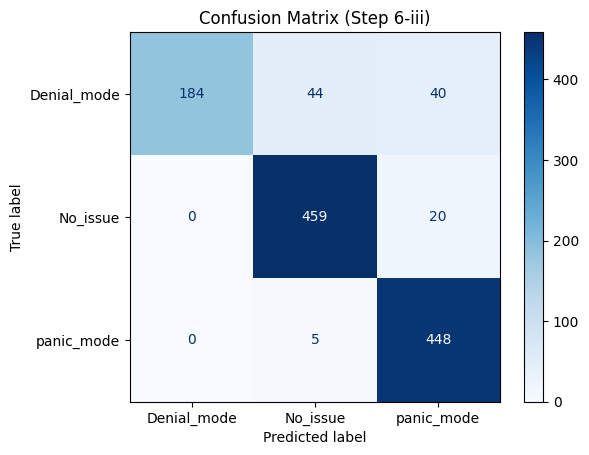

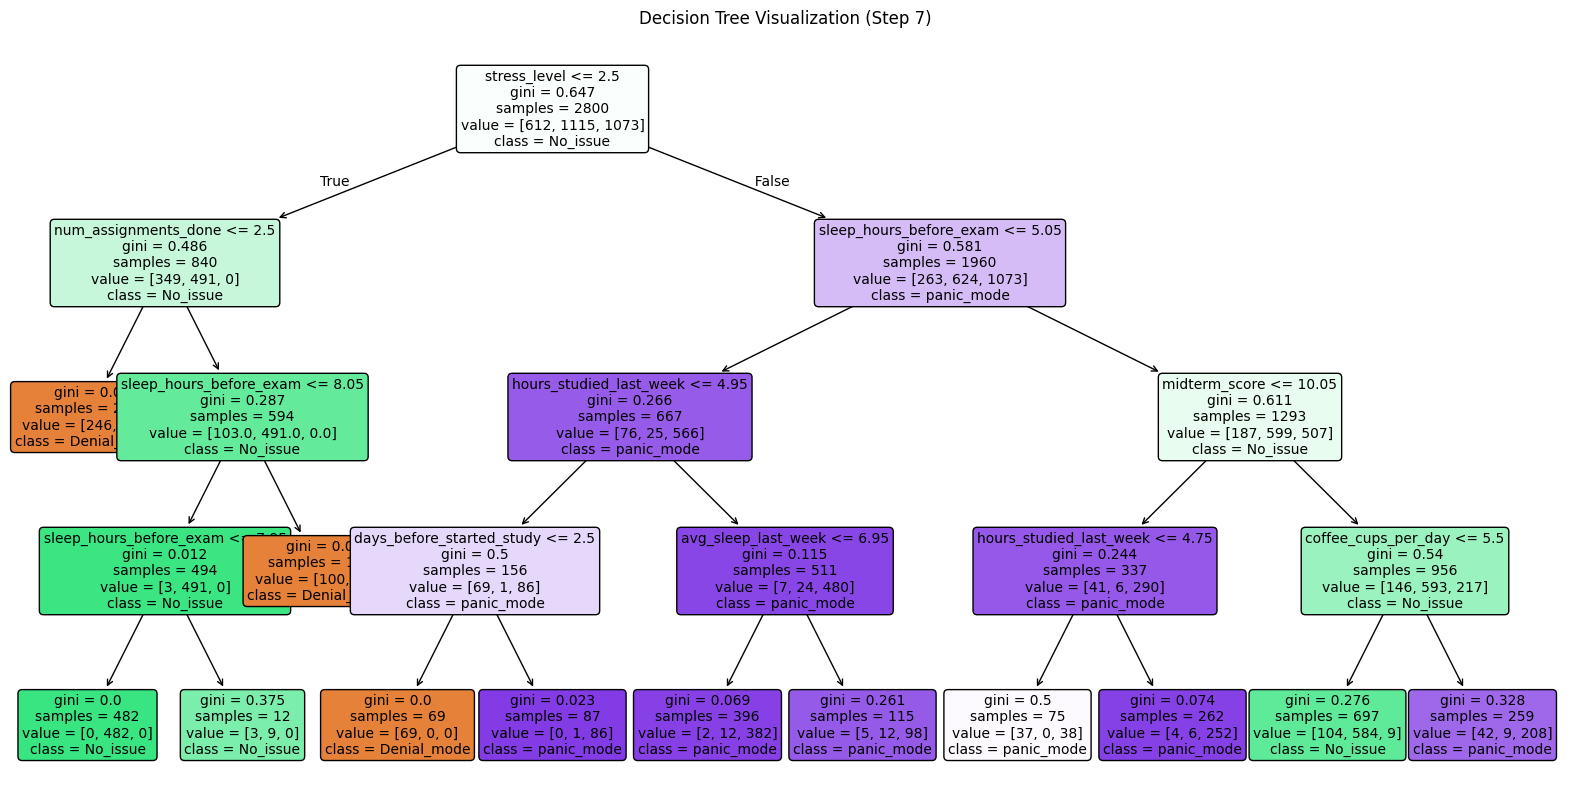

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# Split Data 
# Separate features (X) and target (y)
X = df.drop(columns=['crisis_type'])
y = df['crisis_type']

# Split into 70% train and 30% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Decision Tree ---
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

# Predict on validation data
y_val_pred = dt_model.predict(X_val)

# i. Overall Accuracy
acc = accuracy_score(y_val, y_val_pred)

# ii. Macro-averaged Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='macro')

# iii. Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"--- Validation Metrics ---")
print(f"Overall Accuracy: {acc:.4f}")
print(f"Macro Precision:  {precision:.4f}")
print(f"Macro Recall:     {recall:.4f}")
print(f"Macro F1 Score:   {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le_target.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Step 6-iii)")
plt.show()

# --- Step 7: Plot Tree & Feature Importance ---
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          feature_names=X.columns,  
          class_names=le_target.classes_,
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Decision Tree Visualization (Step 7)")
plt.show()




## 7.

    we can see that the stress level and the sleep hours are the most important features.

## 8.

    To answer this question precisely, we must look at the Confusion Matrix generated in the code. The vertical axis represents the True Labels, and the horizontal axis represents the Predicted Labels. Typically in this type of data, the most frequent confusion occurs between the Panic_mode and Denial_mode classes. The reason is that both groups often have very similar academic indicators, such as low grades or lack of study, but one group has “high stress” (Panic) while the other may have “false low stress” or indifference (Denial). If the model fails to effectively separate the stress_level or hours_studied features at the decision boundary, it will mistake these two for each other, which results in large numbers in the non-diagonal cells corresponding to the intersection of these two classes.

In [65]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score



rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_base = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_params,
    n_iter=10,  # Limits the search to 10 random combinations
    cv=3,       # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
y_val_pred_rf = best_rf.predict(X_val)

print(f"Best RF Params: {rf_search.best_params_}")
print("\n[Bagging] Validation Metrics:")
print(classification_report(y_val, y_val_pred_rf, target_names=le_target.classes_))




gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5]
}

# Initialize model and GridSearchCV
gb_base = GradientBoostingClassifier(random_state=42)
gb_search = GridSearchCV(
    estimator=gb_base,
    param_grid=gb_params,
    cv=3,
    verbose=1,
    n_jobs=-1
)

gb_search.fit(X_train, y_train)

# Best Model & Prediction
best_gb = gb_search.best_estimator_
y_val_pred_gb = best_gb.predict(X_val)

print(f"Best GB Params: {gb_search.best_params_}")
print("\n[Boosting] Validation Metrics:")
print(classification_report(y_val, y_val_pred_gb, target_names=le_target.classes_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RF Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}

[Bagging] Validation Metrics:
              precision    recall  f1-score   support

 Denial_mode       1.00      0.92      0.96       268
    No_issue       0.96      0.96      0.96       479
  panic_mode       0.93      0.98      0.96       453

    accuracy                           0.96      1200
   macro avg       0.97      0.95      0.96      1200
weighted avg       0.96      0.96      0.96      1200

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best GB Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}

[Boosting] Validation Metrics:
              precision    recall  f1-score   support

 Denial_mode       0.98      0.93      0.96       268
    No_issue       0.97      0.95      0.96       479
  panic_mode       0.94      0.98      0.96       453

    accuracy                         

## 7.

    Label Encoding maps nominal categories to integers (e.g., 0, 1, 2), causing linear and distance-based models to incorrectly assume an inherent order or magnitude . One-Hot Encoding is preferred because it creates orthogonal binary vectors, ensuring that all categories are treated as equidistant and independent, preventing the model from learning false mathematical relationships or hierarchies between them.

In [66]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, accuracy_score

classes = le_target.classes_
print(f"Target Classes Order: {classes}")

y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

models_ovr = []
for i, class_name in enumerate(classes):
    clf = DecisionTreeClassifier(max_depth=4, random_state=42)
    clf.fit(X_train, y_train_bin[:, i])
    models_ovr.append(clf)

y_val_probs = []
for clf in models_ovr:
    y_val_probs.append(clf.predict_proba(X_val)[:, 1])

y_val_probs = np.array(y_val_probs).T
y_pred_ovr = np.argmax(y_val_probs, axis=1)

print(classification_report(y_val, y_pred_ovr, target_names=classes))


Target Classes Order: ['Denial_mode' 'No_issue' 'panic_mode']
              precision    recall  f1-score   support

 Denial_mode       1.00      0.92      0.96       268
    No_issue       0.96      0.96      0.96       479
  panic_mode       0.94      0.98      0.96       453

    accuracy                           0.96      1200
   macro avg       0.97      0.95      0.96      1200
weighted avg       0.96      0.96      0.96      1200



## Q5:

    Label Encoding assigns integers (e.g., 0, 1, 2) to categories, which can mislead models into assuming an inherent order or magnitude that does not exist in nominal data. Even in decision trees, this arbitrary ordering can complicate the learning process, forcing the tree to make extra splits to separate classes that are numerically distant but similar in features.

## Q6:

    The difference is in the modeling strategy: The Label Encoding approach trains a single multi-class model to separate all boundaries simultaneously. The One-vs-Rest (One-Hot) approach decomposes the problem into multiple independent binary classifiers, allowing each model to specialize in distinguishing a single specific class from the rest, often simplifying the decision boundaries.

## test

In [67]:
import pandas as pd
import numpy as np

df_test = pd.read_csv('datas/part3/part3_test.csv')

num_cols = df_test.select_dtypes(include=[np.number]).columns
cat_cols = df_test.select_dtypes(exclude=[np.number]).columns

for col in num_cols:
    df_test[col] = df_test[col].fillna(df_test[col].median())
for col in cat_cols:
    df_test[col] = df_test[col].fillna(df_test[col].mode()[0])

df_test['net_preparedness'] = (df_test['num_assignments_done'] / 10) + \
                              (df_test['hours_studied_last_week'] / 40) - \
                              (df_test['stress_level'] / 5)

ai_map = {'none': 0, 'basic': 1, 'strong': 2}
exam_map = {'morning': 0, 'afternoon': 1, 'Evening': 2}

df_test['ai_background'] = df_test['ai_background'].map(ai_map)
df_test['exam_time'] = df_test['exam_time'].map(exam_map)
df_test['mentality_type'] = le_mentality.transform(df_test['mentality_type'])

X_test_final = df_test.copy()

probs_matrix = []
for model in models_ovr:
    probs_matrix.append(model.predict_proba(X_test_final)[:, 1])

probs_matrix = np.array(probs_matrix).T
y_pred_idx = np.argmax(probs_matrix, axis=1)
y_pred_labels = le_target.inverse_transform(y_pred_idx)

df_output = pd.read_csv('datas/part3/part3_test.csv')
df_output['crisis_type'] = y_pred_labels
df_output.to_csv('part3_predicted.csv', index=False)


# part 4:

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

df = pd.read_csv('datas/part4/part4_dataset.csv')

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean()) # fill empty blocks
    else:
        df[col] = df[col].fillna(df[col].mode()[0]) # converts string domain to integer

for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop(columns=['final_exam_score'])
y = df['final_exam_score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

print(f"{'Model':<20} | {'MSE':<10} | {'MAE':<10} | {'R2 Score':<10}")
print("-" * 60)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mse = calculate_mse(y_val, y_pred)
    mae = calculate_mae(y_val, y_pred)
    r2 = calculate_r2(y_val, y_pred)
    
    print(f"{name:<20} | {mse:<10.4f} | {mae:<10.4f} | {r2:<10.4f}")


Model                | MSE        | MAE        | R2 Score  
------------------------------------------------------------
Decision Tree        | 12.3938    | 2.4711     | 0.3699    
Random Forest        | 6.1655     | 1.7434     | 0.6865    
XGBoost              | 7.0907     | 1.8763     | 0.6395    


## test

In [58]:
test_df = pd.read_csv('datas/part4/part4_test.csv')

for col in test_df.columns:
    if test_df[col].dtype in ['int64', 'float64']:
        test_df[col] = test_df[col].fillna(test_df[col].mean())
    else:
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

for col in test_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    test_df[col] = le.fit_transform(test_df[col])

for name, model in models.items():
    predictions = model.predict(test_df)
    output_df = test_df.copy()
    output_df['label'] = predictions
    filename = f"datas/part4/part4_test_{name.replace(' ', '_')}.csv"
    output_df.to_csv(filename, index=False)


## Question 3:

    In Part 4, the project focus shifted from classification to regression to predict the continuous variable ‘final_exam_score’. We preprocessed the dataset by handling missing values with mean/mode imputation and converting categorical features, such as ‘crisis_type’, into numerical values using label encoding. Three regression models—Decision Tree, Random Forest, and XGBoost—were trained on the data split into training and validation sets. Unlike previous sections that utilized classification metrics like Accuracy and F1-score based on discrete categories, we evaluated these models by manually implementing regression metrics: Mean Squared Error (MSE) to penalize large errors, Mean Absolute Error (MAE) for interpretable average error, and R-squared (R2) to measure the variance explained by the models.

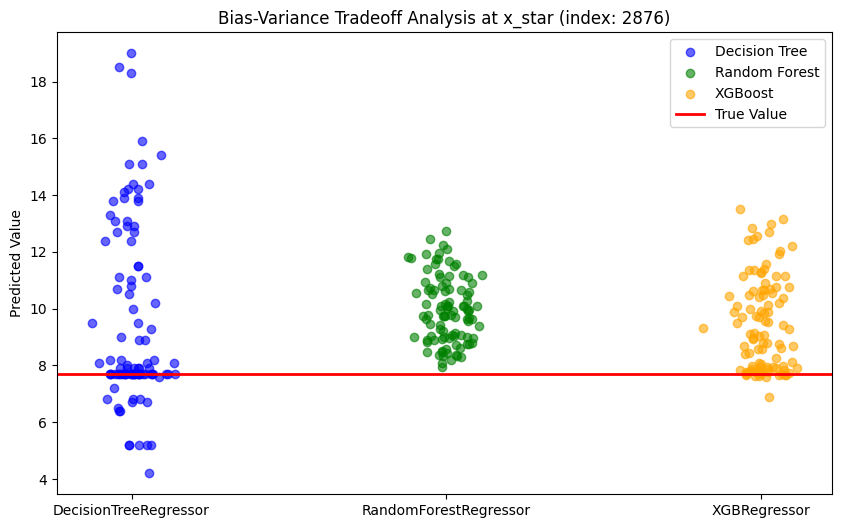

In [57]:
import matplotlib.pyplot as plt
import numpy as np

random_idx = np.random.randint(0, len(X))
x_star = X.iloc[[random_idx]]
true_y = y.iloc[random_idx]

dt_preds = []
rf_preds = []
xgb_preds = []

for _ in range(100):
    sample_indices = np.random.choice(X.index, size=int(0.3 * len(X)), replace=False)
    X_sample = X.loc[sample_indices]
    y_sample = y.loc[sample_indices]
    
    model_dt = DecisionTreeRegressor()
    model_rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    model_xgb = XGBRegressor(n_estimators=100, n_jobs=-1)
    
    model_dt.fit(X_sample, y_sample)
    model_rf.fit(X_sample, y_sample)
    model_xgb.fit(X_sample, y_sample)
    
    dt_preds.append(model_dt.predict(x_star)[0])
    rf_preds.append(model_rf.predict(x_star)[0])
    xgb_preds.append(model_xgb.predict(x_star)[0])

plt.figure(figsize=(10, 6))

plt.scatter(np.random.normal(0, 0.05, 100), dt_preds, alpha=0.6, label='Decision Tree', c='blue')
plt.scatter(np.random.normal(1, 0.05, 100), rf_preds, alpha=0.6, label='Random Forest', c='green')
plt.scatter(np.random.normal(2, 0.05, 100), xgb_preds, alpha=0.6, label='XGBoost', c='orange')

plt.axhline(y=true_y, color='red', linestyle='-', linewidth=2, label='True Value')

plt.xticks([0, 1, 2], ['DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor'])
plt.ylabel('Predicted Value')
plt.title(f'Bias-Variance Tradeoff Analysis at x_star (index: {random_idx})')
plt.legend()
plt.show()
